In [1]:
# MAIN NOTEBOOK

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from scipy import stats
from functools import partial
np.set_printoptions(suppress=True)
import seaborn as sns
from tqdm.notebook import tqdm
import tensorflow as tf
from numba import jit

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
## Mount my Google Drive - This is the working directory, where figures / checkpoints are stored and modules are imported from
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Add required directories to sys.path so imports work
import sys
sys.path.append('/content/drive/MyDrive/AIAgainstCorona-main/')
sys.path.append('/content/drive/MyDrive/AIAgainstCorona-main/deep_bayes/')

In [5]:
from deep_bayes.models import BayesFlow, InvariantNetwork
from deep_bayes.training import train_online
from deep_bayes.losses import maximum_likelihood_loss
from deep_bayes.viz import plot_true_est_scatter, plot_true_est_posterior

# Load US federal state data

In [6]:
"""
Ns, the population numbers of the federal states. Some are commented out
because of suspicious spikes in the ported data
"""
Ns = [
      5024279,    # Alabama
                                              # 731545,       # Alaska
      7151502,    # Arizona
      3011524,    # Arkansas
      39538223,   # California
      5773714,    # Colorado
      3605944,    # Connecticut
      989948,     # Delaware
      21538187,   # Florida
      10711908,   # Georgia
                                              # 1455271,      # Hawaii 
                                              # 1839106,      # Idaho 
      12812508,   # Illinois
                                              # 6732000,      # Indiana 
      3155070,    # Iowa
      2937880,    # Kansas
      4505836,    # Kentucky
      4657757,    # Louisiana
                                              # 1362359,      # Maine
      6177224,    # Maryland
      7029917,    # Massachusetts   
      10077331,   # Michigan
      5706494,    # Minnesota 
      2961279,    # Mississippi
      6154913,    # Missouri
                                              # 1084225,      # Montana
                                              # 1961605,      # Nebraska
      3108462,    # Nevada
                                              # 1377529,      # New Hampshire
      9288994,    # New Jersey
      2117522,    # New Mexico
                                              # 8804190,      # New York
      10439388,   # North Carolina
                                              # 779094,       # North Dakota
      11799448,   # Ohio
      3959353,    # Oklahoma
      4237256,    # Oregon
      13002700,   # Pennsylvania
      1097379,    # Rhode Island
      5118425,    # South Carolina
                                              # 886667,       # South Dakota
      6916897,    # Tennessee
      29145505,   # Texas
                                              # 3271616,      # Utah
                                              # 643077,       # Vermont
      8631393,    # Virginia
                                              # 689545,       # Washington
                                              # 1793716,      # West Virginia
      5893718,    # Wisconsin
                                              # 576851,       # Wyoming
    ]

In [7]:
def load_state_data(data, state, begin_date = '2020-04-10', end_date = '2020-06-08'):
    """Loads data per state."""
    
    data_state = data.loc[data['federalstate'] == state]
    
    index_start = data_state[data_state['date'] == begin_date].index[0]
    index_end = data_state[data_state['date'] == end_date].index[0]
    
    new_I = data_state.loc[index_start:index_end, :]['newinfections'].values
    new_D = data_state.loc[index_start:index_end, :]['newdeaths'].values
    
    return np.stack((new_I, new_D)).astype(np.float32).T


def load_all_data(begin_date = '2020-04-10', end_date = '2020-06-08'):
    
    # Data
    d = pd.read_csv('/content/drive/MyDrive/AIAgainstCorona-main/data/covid19-US.csv')

    # States
    states = sorted(d['federalstate'].unique().tolist())
    
    # Dict with data
    data_dict = {s: {'N': N, 'x': None, 'x_tensor': None} for s, N in zip(states, Ns)}
    for s in states:
        data_state = load_state_data(d, s, begin_date, end_date)
        data_dict[s]['x'] = data_state
        data_dict[s]['x_tensor'] = tf.convert_to_tensor(data_state[np.newaxis, :, :], dtype=tf.float32)
    return data_dict

In [8]:
data_dict = load_all_data()
n_states = len(data_dict)
T = data_dict['Alabama']['x'].shape[0]
N_min = min(Ns)
N_max = max(Ns)
grand_mean = np.mean(np.array([np.mean(data_dict[s]['x'], axis=0) for s in data_dict.keys()]), axis=0)
grand_std = np.std(np.array([np.std(data_dict[s]['x'], axis=0) for s in data_dict.keys()]), axis=0)

In [9]:
print(T)
print(N_min)
print(N_max)
print(grand_mean)
print(grand_std)

58
989948
39538223
[576.1226   32.87931]
[253.71463   24.189444]


# Plot American Active Cases

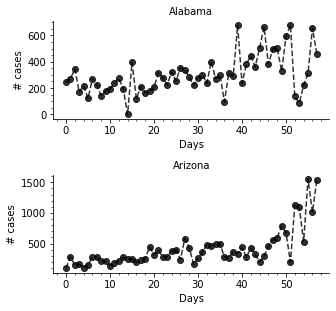

In [10]:
with plt.style.context('/content/drive/MyDrive/AIAgainstCorona-main/latex_document.mplstyle'):
  f, axarr = plt.subplots(2, 1, figsize=(4.7747, 1.5*2.9509))

  for s, ax in zip(data_dict, axarr.flat):
      
      ax.plot(data_dict[s]['x'][:, 0], 
              marker='o', 
              label='Reported cases', 
              color='black', 
              linestyle='dashed', 
              alpha=0.8)
      
      ax.set_title(s)
      ax.spines['top'].set_visible(False)
      ax.spines['right'].set_visible(False)
      ax.set_xlabel('Days')
      ax.set_ylabel('# cases')
      
  f.tight_layout()
  plt.savefig('/content/drive/MyDrive/AIAgainstCorona-main/us_figures/new-cases-us.pdf')

# Plot US Deaths

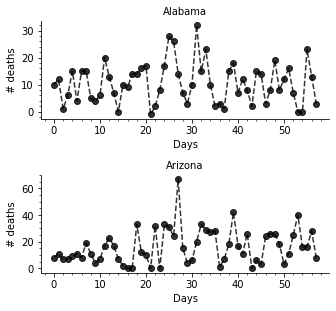

In [11]:
with plt.style.context('/content/drive/MyDrive/AIAgainstCorona-main/latex_document.mplstyle'):
  f, axarr = plt.subplots(2, 1, figsize=(4.7747, 1.5*2.9509))

  for s, ax in zip(data_dict, axarr.flat):
      
      ax.plot(data_dict[s]['x'][:, 1], 
              marker='o', 
              label='Reported cases', 
              color='black', 
              linestyle='dashed', 
              alpha=0.8)
      
      ax.set_title(s)
      ax.spines['top'].set_visible(False)
      ax.spines['right'].set_visible(False)
      ax.set_xlabel('Days')
      ax.set_ylabel('# deaths')
      
  f.tight_layout()

# Prior and Model

In [12]:
alpha_f = (0.7**2)*((1-0.7)/(0.17**2) - (1-0.7))
beta_f = alpha_f*(1/0.7 - 1)

def prior_sir():
    """
    Implements batch sampling from a stationary prior over the parameters
    of the non-stationary SIR model.
    """
    
    t1 = np.random.normal(loc=8, scale=3)
    t2 = np.random.normal(loc=15, scale=1)
    t3 = np.random.normal(loc=22, scale=1)
    t4 = np.random.normal(loc=66, scale=1) 
    delta_t1 = np.random.lognormal(mean=np.log(3), sigma=0.3)
    delta_t2 = np.random.lognormal(mean=np.log(3), sigma=0.3)
    delta_t3 = np.random.lognormal(mean=np.log(3), sigma=0.3)
    delta_t4 = np.random.lognormal(mean=np.log(3), sigma=0.3)
    lambd0 = np.random.lognormal(mean=np.log(1.2), sigma=0.5)
    lambd1 = np.random.lognormal(mean=np.log(0.6), sigma=0.5)
    lambd2 = np.random.lognormal(mean=np.log(0.3), sigma=0.5)
    lambd3 = np.random.lognormal(mean=np.log(0.1), sigma=0.5)
    lambd4 = np.random.lognormal(mean=np.log(0.15), sigma=0.5)
    mu = np.random.lognormal(mean=np.log(1/8), sigma=0.2)
    f_i = np.random.beta(a=alpha_f, b=beta_f)
    phi_i = stats.vonmises(kappa=0.01).rvs()
    f_d = np.random.beta(a=alpha_f, b=beta_f)
    phi_d = stats.vonmises(kappa=0.01).rvs()
    D_i = np.random.lognormal(mean=np.log(8), sigma=0.2)
    D_d = np.random.lognormal(mean=np.log(8), sigma=0.2)
    E0 = np.random.gamma(shape=2, scale=30)
    scale_I = np.random.gamma(shape=1, scale=5)
    scale_D = np.random.gamma(shape=1, scale=5)
    return [t1, t2, t3, t4, delta_t1, delta_t2, delta_t3, delta_t4, 
            lambd0, lambd1, lambd2, lambd3, lambd4, mu, 
            f_i, phi_i, f_d, phi_d, 
            D_i, D_d, E0, scale_I, scale_D]

def prior_secir():
    """
    Implements batch sampling from a stationary prior over the parameters
    of the non-stationary SIR model.
    """
    
    alpha = np.random.uniform(low=0.005, high=0.9)
    beta = np.random.lognormal(mean=np.log(0.25), sigma=0.3)
    gamma = np.random.lognormal(mean=np.log(1/6.5), sigma=0.5)
    eta = np.random.lognormal(mean=np.log(1/3.2), sigma=0.3)
    theta = np.random.uniform(low=1/14, high=1/3)
    delta = np.random.uniform(low=0.01, high=0.3)
    d = np.random.uniform(low=1/14, high=1/3)
    return [alpha, beta, gamma, eta, theta, delta, d]

def calc_lambda_array(sim_lag, lambd0, lambd1, lambd2, lambd3, lambd4, 
                      t1, t2, t3, t4, delta_t1, delta_t2, delta_t3, delta_t4, T):
    """Computes the array of time-varying contact rates/transimission probabilities."""
    
    # Array of initial lambdas
    lambd0_arr = np.array([lambd0] * (t1+sim_lag))
    
    # Compute lambd1 array
    if delta_t1 == 1:
        lambd1_arr = np.array([lambd1] * (t2-t1))
    else:
        lambd1_arr = np.linspace(lambd0, lambd1, delta_t1)
        lambd1_arr = np.append(lambd1_arr, [lambd1] * (t2-t1-delta_t1))
        
    # Compute lambd2 array
    if delta_t2 == 1:
        lambd2_arr = np.array([lambd2] * (t3-t2))
    else:
        lambd2_arr = np.linspace(lambd1, lambd2, delta_t2)
        lambd2_arr = np.append(lambd2_arr, [lambd2] * (t3-t2-delta_t2))
        
    # Compute lambd3 array
    if delta_t3 == 1:
        lambd3_arr = np.array([lambd3] * (t4-t3))
    else:
        lambd3_arr = np.linspace(lambd3, lambd4, delta_t3)
        lambd3_arr = np.append(lambd3_arr, [lambd3] * (t4-t3-delta_t3))
        
    # Compute lambd4 array
    if delta_t4 == 1:
        lambd4_arr = np.array([lambd4] * (T-t4))
    else:
        lambd4_arr = np.linspace(lambd3, lambd4, delta_t4)
        lambd4_arr = np.append(lambd4_arr, [lambd4] * (T-t4-delta_t4))
    
    #return np.r_[lambd0_arr, lambd1_arr, lambd2_arr, lambd3_arr, lambd4_arr]
    return np.concatenate((lambd0_arr, lambd1_arr, lambd2_arr, lambd3_arr, lambd4_arr), axis=0)

@jit(nopython=True)
def non_stationary_SEICR_fast(T, sim_lag, N, E0, beta, alpha, eta, theta, delta, mu, gamma,
                              d, lambd_arr, f_i, f_d, phi_i, phi_d, delay_i, delay_d):
    # Initial conditions
    S = np.zeros(T+sim_lag)
    E = np.zeros(T+sim_lag)
    C = np.zeros(T+sim_lag)
    I = np.zeros(T+sim_lag)
    R = np.zeros(T+sim_lag)
    D = np.zeros(T+sim_lag)
    
    S[0] = N-E0
    E[0] = E0
    #S, E, C, I, R, D = [N-E0], [E0], [0], [0], [0], [0]
    
    # Containers
    I_news = np.zeros(T+sim_lag)
    D_news = np.zeros(T+sim_lag)
    
    # Reported new cases
    I_data = np.zeros(T)
    D_data = np.zeros(T)
    fs_i = np.zeros(T)
    fs_d = np.zeros(T)

    # Simulate T-1 tiemsteps
    for t in range(T+sim_lag):
        
        # Calculate new exposed cases
        E_new = lambd_arr[t] * ((C[t] + beta*I[t])/N)*S[t]
    
        # Remove exposed from susceptible
        S_t = S[t] - E_new
        
        # Calculate current exposed by adding new exposed and
        # subtracting the exposed becoming carriers.
        E_t = E[t] + E_new - gamma*E[t]
        
        # Calculate current carriers by adding the new exposed and subtracting
        # those who will develop symptoms and become detected and those who
        # will go through the disease asymptomatically.
        C_t = C[t] + gamma*E[t] - (1-alpha)*eta*C[t] - alpha*theta*C[t]
        
        # Calculate current infected by adding the symptomatic carriers and 
        # subtracting the dead and recovered. The newly infected are just the 
        # carriers who get detected.
        I_t = I[t] + (1-alpha)*eta*C[t] - (1-delta)*mu*I[t] - delta*d*I[t]
        I_new = (1-alpha)*eta*C[t]

        # Calculate current recovered by adding the symptomatic and asymptomatic
        # recovered. The newly recovered are only the detected recovered
        R_t = R[t] + alpha*theta*C[t] + (1-delta)*mu*I[t]
        
        # Calculate the current dead
        D_t = D[t] + delta*d*I[t]
        D_new = delta*d*I[t]
        
        # Ensure some numerical 
        S_t = np.max(np.array([np.min(np.array([S_t, N])), 0]))
        E_t = np.max(np.array([np.min(np.array([E_t, N])), 0]))
        C_t = np.max(np.array([np.min(np.array([C_t, N])), 0]))
        I_t = np.max(np.array([np.min(np.array([I_t, N])), 0]))
        R_t = np.max(np.array([np.min(np.array([R_t, N])), 0]))
        D_t = np.max(np.array([np.min(np.array([D_t, N])), 0]))
        
        # Keep track of process over time
        S[t+1] = S_t
        E[t+1] = E_t
        C[t+1] = C_t
        I[t+1] = I_t
        R[t+1] = R_t
        D[t+1] = D_t
        I_news[t+1] = I_new
        D_news[t+1] = D_new

        """S.append(S_t)
        E.append(E_t)
        C.append(C_t)
        I.append(I_t)
        R.append(R_t)
        D.append(D_t)
        I_news.append(I_new)
        D_news.append(D_new)"""
        
        # From here, start adding new cases with delay D
        # Note, we assume the same delay
        if t >= sim_lag:
            
            # Compute lags and add to data arrays
            fs_i[t-sim_lag] = (1-f_i)*(1 - np.abs( np.sin( (np.pi/7) * (t-sim_lag) - 0.5*phi_i)) )
            fs_d[t-sim_lag] = (1-f_d)*(1 - np.abs( np.sin( (np.pi/7) * (t-sim_lag) - 0.5*phi_d)) )
            I_data[t-sim_lag] = I_news[t-delay_i]
            D_data[t-sim_lag] = D_news[t-delay_d]
    return I_data, D_data, fs_i, fs_d

def non_stationary_SEICR(params_sir, params_secir, N, T, sim_diff=16):
    """
    Performs a forward simulation from the stationary SIR model.
    """
    
    # Extract parameters 
    t1, t2, t3, t4, delta_t1, delta_t2, delta_t3, delta_t4, lambd0, lambd1, lambd2, lambd3, lambd4, mu, f_i, phi_i, f_d, phi_d, delay_i, delay_d, E0, scale_I, scale_D = params_sir
    alpha, beta, gamma, eta, theta, delta, d = params_secir
    
    # Round integer parameters
    t1, t2, t3, t4 = int(round(t1)), int(round(t2)), int(round(t3)), int(round(t4))
    delta_t1, delta_t2, delta_t3, delta_t4 = int(round(delta_t1)), int(round(delta_t2)), int(round(delta_t3)), int(round(delta_t4))
    E0 = max(1, np.round(E0)) 
    delay_i = int(round(delay_i)) 
    delay_d = int(round(delay_d)) 
    
    # Impose constraints
    assert sim_diff > delay_i
    assert sim_diff > delay_d
    assert t1 > 0 and t2 > 0 and t3 > 0 and t4 > 0
    assert t1 < t2 < t3 < t4
    assert delta_t1 > 0 and delta_t2 > 0 and delta_t3 > 0 and delta_t4 > 0
    assert t2 - t1 >= delta_t1 and t3 - t2 >= delta_t2 and t4-t3 >= delta_t3 and T-t4 >= delta_t4

    # Calculate lambda arrays
    # Lambda0 is the initial contact rate which will be consecutively
    # reduced via the government measures
    sim_lag = sim_diff - 1
    lambd_arr = calc_lambda_array(sim_lag, lambd0, lambd1, lambd2, lambd3, lambd4, 
                                  t1, t2, t3, t4, delta_t1, delta_t2, delta_t3, delta_t4, T)
 
    # Call faster function
    I_data, D_data, fs_i, fs_d = non_stationary_SEICR_fast(T, sim_lag, N, E0, beta, alpha, eta, theta, 
                                               delta, mu, gamma, d, lambd_arr, f_i, f_d, 
                                               phi_i, phi_d, delay_i, delay_d)
                    
    # Compute weekly modulation
    I_data = (1-fs_i) * I_data
    D_data = (1-fs_d) * D_data

    # Add noise
    I_data = stats.t(df=4, loc=I_data, scale=np.sqrt(I_data)*scale_I).rvs()
    D_data = stats.t(df=4, loc=D_data, scale=np.sqrt(D_data)*scale_D).rvs()
    
    return np.stack((I_data, D_data)).T

@jit(nopython=True)
def SECIR_asymptomatic(params_sir, params_secir, N, T, sim_diff=16):
    """
    Performs a forward simulation from the stationary SIR model.
    """
    
    # Extract parameters 
    t1, t2, t3, t4, delta_t1, delta_t2, delta_t3, delta_t4, lambd0, lambd1, lambd2, lambd3, lambd4, mu, f, phi, delay_i, delay_r, delay_d, E0, scale_I, scale_R, scale_D = params_sir
    alpha, beta, gamma, eta, theta, delta, d = params_secir
    
    # Round integer parameters
    t1, t2, t3, t4 = int(round(t1)), int(round(t2)), int(round(t3)), int(round(t4))
    delta_t1, delta_t2, delta_t3, delta_t4 = int(round(delta_t1)), int(round(delta_t2)), int(round(delta_t3)), int(round(delta_t4))
    E0 = max(1, np.round(E0)) 
    delay_i = int(round(delay_i)) 
    delay_r = int(round(delay_r)) 
    delay_d = int(round(delay_d)) 
    
    # Impose constraints
    assert sim_diff > delay_i
    assert sim_diff > delay_r
    assert sim_diff > delay_d
    assert t1 > 0 and t2 > 0 and t3 > 0 and t4 > 0
    assert t1 < t2 < t3 < t4
    assert delta_t1 > 0 and delta_t2 > 0 and delta_t3 > 0 and delta_t4 > 0
    assert t2 - t1 >= delta_t1 and t3 - t2 >= delta_t2 and t4-t3 >= delta_t3 and T-t4 >= delta_t4

    # Calculate lambda arrays
    # Lambda0 is the initial contact rate which will be consecutively
    # reduced via the government measures
    sim_lag = sim_diff - 1
    lambd_arr = calc_lambda_array(sim_lag, lambd0, lambd1, lambd2, lambd3, lambd4, 
                                  t1, t2, t3, t4, delta_t1, delta_t2, delta_t3, delta_t4, T)
 
    # Initial conditions
    S, E, C, I, R, D = [N-E0], [E0], [0], [0], [0], [0]
    
    # Containers
    A_data = [0]
 
    # Simulate T-1 tiemsteps
    for t in range(T+sim_lag):
        
        # Calculate new exposed cases
        E_new = lambd_arr[t] * ((C[t] + beta*I[t])/N)*S[t]
    
        # Remove exposed from susceptible
        S_t = S[t] - E_new
        
        # Calculate current exposed by adding new exposed and
        # subtracting the exposed becoming carriers.
        E_t = E[t] + E_new - gamma*E[t]
        
        # Calculate current carriers by adding the new exposed and subtracting
        # those who will develop symptoms and become detected and those who
        # will go through the disease asymptomatically.
        C_t = C[t] + gamma*E[t] - (1-alpha)*eta*C[t] - alpha*theta*C[t]
        
        # Calculate current infected by adding the symptomatic carriers and 
        # subtracting the dead and recovered. The newly infected are just the 
        # carriers who get detected.
        I_t = I[t] + (1-alpha)*eta*C[t] - (1-delta)*mu*I[t] - delta*d*I[t]
        I_new = (1-alpha)*eta*C[t]
        
        # Calculate current recovered by adding the symptomatic and asymptomatic
        # recovered. The newly recovered are only the detected recovered
        R_t = R[t] + alpha*theta*C[t] + (1-delta)*mu*I[t]
        R_new = (1-delta)*mu*I[t]
        
        # Calculate the current dead
        D_t = D[t] + delta*d*I[t]
        D_new = delta*d*I[t]
        
        # Ensure some numerical onstraints
        S_t = np.max(np.array([np.min(np.array([S_t, N])), 0]))
        E_t = np.max(np.array([np.min(np.array([E_t, N])), 0]))
        C_t = np.max(np.array([np.min(np.array([C_t, N])), 0]))
        I_t = np.max(np.array([np.min(np.array([I_t, N])), 0]))
        R_t = np.max(np.array([np.min(np.array([R_t, N])), 0]))
        D_t = np.max(np.array([np.min(np.array([D_t, N])), 0]))
        
        # Keep track of process over time
        S.append(S_t)
        E.append(E_t)
        C.append(C_t)
        I.append(I_t)
        R.append(R_t)
        D.append(D_t)
        
        # Add the new saymptomatic cases
        A_data.append(alpha*theta*C_t)
    
    # Cumulative numbers
    A_data = np.cumsum(A_data)
    return A_data

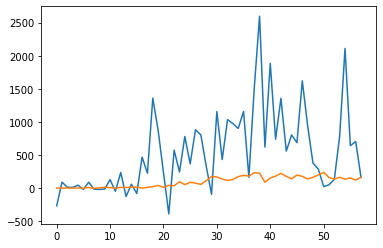

In [15]:
"""
Creating TS from non_stationary SEICR - If assertions fail, just run it again!
"""
p1 = prior_sir()
p2 = prior_secir()
ts = non_stationary_SEICR(p1, p2, 100000, T)
plt.plot(ts)

# Data Generator for Neural Net

In [16]:
def data_generator(batch_size, T=None, N=None, T_min=10, T_max=90, sim_diff=16,
                   N_min=10000, N_max=70000000, to_tensor=True, seed=None):
    """
    Runs the forward model 'batch_size' times by first sampling fromt the prior
    theta ~ p(theta) and running x ~ p(x|theta).
    ----------
    
    Arguments:
    batch_size : int -- the number of samples to draw from the prior
    simulator  : callable -- the data simulator
    to_tensor  : boolean -- converts theta and x to tensors if True
    ----------
    
    Output:
    theta : tf.Tensor or np.ndarray of shape (batch_size, theta_dim) - the data gen parameters 
    x     : tf.Tensor of np.ndarray of shape (batch_size, n_obs, x_dim)  - the generated data
    """
    
    if seed is not None:
        np.random.seed(seed)
        
    # Variable-size t
    if T is None:
        T = np.random.randint(T_min, T_max+1)
    
    # Variable size N
    if N is None:
        N = np.random.randint(N_min, N_max)
        
    # Generate data
    # x is a np.ndarray of shape (batch_size, n_obs, x_dim)
    x = []
    theta = []
    for i in range(batch_size):
        
        # Reject meaningless simulaitons
        x_i = None
        while x_i is None:
            try:
                
                theta1 = prior_sir()
                theta2 = prior_secir()
                x_i = non_stationary_SEICR(theta1, theta2, N, T, sim_diff=sim_diff)
                x_i = (x_i - grand_mean) / grand_std
            except:
                 pass
        # Simulate SECIR
        x.append(x_i)
        theta.append(theta1 + theta2)
    x = np.array(x)

    # Convert to tensor, if specified 
    if to_tensor:
        theta = tf.convert_to_tensor(theta, dtype=tf.float32)
        x = tf.convert_to_tensor(x, dtype=tf.float32)
    return {'theta': theta,  'x': x}

# Training Hyperparameters

In [17]:
# Network hyperparameters
inv_meta = {
    'n_units': [196, 196, 196],
    'activation': 'elu',
    'w_decay': 0.0,
    'initializer': 'glorot_uniform'
}
n_summary = 150
n_inv_blocks = 8

param_names = [r'$t_1$', r'$t_2$', r'$t_3$', r'$t_4$',
               r'$\Delta t_1$', r'$\Delta t_2$', r'$\Delta t_3$', r'$\Delta t_4$',
               r'$\lambda_0$', r'$\lambda_1$', r'$\lambda_2$', r'$\lambda_3$', r'$\lambda_4$', 
               r'$\mu$', r'$f_I$', r'$\phi_I$', 
               r'$f_D$', r'$\phi_D$',
               r'$D_I$', r'$D_D$', r'$E_0$', r'$\sigma_I$', r'$\sigma_D$', 
               r'$\alpha$', r'$\beta$', r'$\gamma$',
               r'$\eta$', r'$\theta$', r'$\delta$', r'$d$']

theta_dim = len(param_names)
n_test = 300

# Training and optimizer hyperparameters
batch_size = 64
epochs = 0
iterations_per_epoch = 100
n_samples_posterior = 2000
clip_value = 5.


starter_learning_rate = 0.0005
global_step = tf.Variable(0, dtype=tf.int32)
decay_steps = 1000
decay_rate = .99
learning_rate = tf.compat.v1.train.exponential_decay(starter_learning_rate, global_step, 
                                           decay_steps, decay_rate, staircase=True)
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

In [18]:
data_gen = partial(data_generator, T=T, N=None, N_min=N_min, N_max=N_max, sim_diff=16)

In [19]:
class MultiConvLayer(tf.keras.Model):
    """Implements an inception-inspired conv layer using different kernel sizes"""
    def __init__(self, n_filters=32, strides=1):
        super(MultiConvLayer, self).__init__()
        
        self.convs = [
            tf.keras.layers.Conv1D(n_filters//2, kernel_size=f, strides=strides, 
                                   padding='causal', activation='relu', kernel_initializer='glorot_uniform')
            for f in range(2, 8)
        ]
        self.dim_red = tf.keras.layers.Conv1D(n_filters, 1, 1, 
                                              activation='relu', kernel_initializer='glorot_uniform')
        
    def call(self, x):
        """x is a timeseries of dimensions B timestamps, n_features"""
        
        out = tf.concat([conv(x) for conv in self.convs], axis=-1)
        out = self.dim_red(out)
        return out
    
    
class MultiConvNet(tf.keras.Model):
    """Implements an inception-inspired conv layer using different kernel sizes"""
    def __init__(self, n_layers=3, n_filters=64, strides=1):
        super(MultiConvNet, self).__init__()
        
        self.net = tf.keras.Sequential([
            MultiConvLayer(n_filters, strides)
            for _ in range(n_layers)
        ])
        
        #self.lstm = tf.keras.layers.CuDNNLSTM(n_filters)
        self.lstm = tf.keras.layers.LSTM(n_filters)

    def call(self, x, **args):
        """x is a timeseries of dimensions B timestamps, n_features"""
        
        out = self.net(x)
        out = self.lstm(out)
        return out
    
    
class SummaryNet(tf.keras.Model):
    def __init__(self, n_summary):
        super(SummaryNet, self).__init__()
        self.net_I = MultiConvNet(n_filters=n_summary//2)
        self.net_D = MultiConvNet(n_filters=n_summary//2)
    
    def call(self, x, **args):
        """x is a timeseries of dimensions B timestamps, n_features"""
        
        x = tf.split(x, 2, axis=-1)
        x_i = self.net_I(x[0])
        x_d = self.net_D(x[1])
        return tf.concat([x_i, x_d], axis=-1)

In [20]:
summary_net = SummaryNet(n_summary)
model = BayesFlow(inv_meta, n_inv_blocks, theta_dim, summary_net=summary_net, permute=True)

## Load pretrained and create a new checkpoint

In [21]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, '/content/drive/MyDrive/AIAgainstCorona-main/checkpoints/GermanyStates', max_to_keep=10)


checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Restored from /content/drive/MyDrive/AIAgainstCorona-main/checkpoints/GermanyStates/ckpt-89


In [22]:
def plot_posteriors_state(state, n_samples, data_dict, figsize=(24, 10), bins=30):
    """Plots full posteriors for each state."""
    
    
    norm_data = (data_dict[state]['x_tensor'] - grand_mean) / grand_std
    samples = model.sample(norm_data, n_samples, to_numpy=True)
    idx_nonzero = [i for i, e in enumerate(param_names) if e != '$\\phi_I$' and e != '$\\phi_D$']
    samples = samples[np.sum(samples[:, idx_nonzero] < 0, axis=1) == 0]
    idx_alpha = param_names.index('$\\alpha$')
    print('Number of valid samples: ', samples.shape[0])
    
    f, ax = plt.subplots(6, 5, figsize=figsize)
    for i in range(theta_dim):
        sns.distplot(samples[:, i], kde=False, bins=bins, ax=ax.flat[i], 
                     hist_kws={'color': '#415ab5', 
                               'alpha': 0.8, 
                               'edgecolor': 'white', 
                               'linewidth': 1.0})
        ax.flat[i].spines['right'].set_visible(False)
        ax.flat[i].spines['top'].set_visible(False)
        ax.flat[i].axvline(np.median(samples[:, i]), color='black', linestyle='dashed')
        ax.flat[i].set_title(param_names[i], pad=0.3)
        if i == idx_alpha:
            align = 'right'
            xx = 0.5
        else:
            align = 'left'
            xx = 0.7
        ax.flat[i].text(xx, 0.7, r'$Med={:.2f}$'.format(np.median(samples[:, i])),
                     horizontalalignment=align,
                     verticalalignment='center',
                     transform=ax.flat[i].transAxes,
                     size=12)
    f.tight_layout()
    plt.show()


def plot_predictions(n_samples, 
                     data_dict, 
                     logscale=False, 
                     sim_diff=16, 
                     plot_quantiles=True, 
                     figsize=(20, 10), 
                     cumulative=False,
                     infected=True):
    """Plots the posterior predictive."""
    
    with plt.style.context('/content/drive/MyDrive/AIAgainstCorona-main/latex_document.mplstyle'):

      # Init figure
      f, axarr = plt.subplots(2, 1, figsize=figsize)
      
      # For each state
      for state, ax in zip(data_dict, axarr.flat):
          print(state)
          
          # Sample from approximate posterior
          norm_data = (data_dict[state]['x_tensor'] - grand_mean) / grand_std
          if state == 'Hamburg':
              samples = model.sample(norm_data, 20000, to_numpy=True)
          else:
              samples = model.sample(norm_data, n_samples, to_numpy=True)
          idx_nonzero = [i for i, e in enumerate(param_names) if e != '$\\phi_I$' and e != '$\\phi_D$']
          samples = samples[np.sum(samples[:, idx_nonzero] < 0, axis=1) == 0]
          print('Samples obtained for {}: {}'.format(state, samples.shape[0]))
                
          # Simulate an outbreak with posterior samples
          sims = []
          rej = 0
          for i in range(samples.shape[0]): 
              try:
                  sim_cases = non_stationary_SEICR(samples[i, :-7], 
                                                  samples[i, -7:], 
                                                  data_dict[state]['N'], 
                                                  T, 
                                                  sim_diff=sim_diff)
                  sims.append(sim_cases)
              except:
                  rej += 1
          print('Number of rejected simulation for {}: {}'.format(state, rej))
          sims = np.array(sims)
          
          # Determine whether cumulative numebrs are to be plotted   
          if cumulative:
              sims = np.cumsum(sims, axis=1)
              data_to_plot = np.cumsum(data_dict[state]['x'], axis=0)
          meds = np.median(sims, axis=0)
          
                
          if infected:
              sims = sims[:, :, 0]
              data_to_plot = data_to_plot[:, 0]
              meds = meds[:, 0]
          else:
              sims = sims[:, :, 1]
              data_to_plot = data_to_plot[:, 1]
              meds = meds[:, 1]
          
          color = 'blue' if infected else 'red'
          y_label = 'Infected' if infected else 'Deaths'
          
                # Compute quantiles
          qs_50 = np.quantile(sims, q=[0.25, 0.75], axis=0)
          qs_90 = np.quantile(sims, q=[0.05, 0.95], axis=0)
          qs_95 = np.quantile(sims, q=[0.025, 0.975], axis=0)
          
          # Plot True
          ax.plot(data_to_plot,
                  marker='o', 
                  label='Reported cases', 
                  color='black', 
                  linestyle='dashed', 
                  alpha=0.8)
                
          # Plot medians
          ax.plot(meds, label='Median predicted cases', color=color, lw=2)
          
          # Plot quantiles
          if plot_quantiles:
              ax.fill_between(range(T), qs_50[0, :], qs_50[1, :], color=color, alpha=0.3, label='50% CI')
              ax.fill_between(range(T), qs_90[0, :], qs_90[1, :], color=color, alpha=0.2, label='90% CI')
              ax.fill_between(range(T), qs_95[0, :], qs_95[1, :], color=color, alpha=0.1, label='95% CI')
          
          ax.set_title(state)
          ax.spines['top'].set_visible(False)
          ax.spines['right'].set_visible(False)
          ax.set_xlabel('Days')
          ax.set_ylabel('Number of {}'.format(y_label))
          ax.legend(loc='upper left')
                
          if logscale:
              ax.set_yscale('log')

      f.tight_layout()
      plt.savefig('/content/drive/MyDrive/AIAgainstCorona-main/us_figures/predictions.pdf')
      plt.show()

In [23]:
all_losses = np.asarray([])
for ep in range(1, epochs+1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        losses = train_online(model=model, 
                              optimizer=optimizer, 
                              data_gen=data_gen, 
                              loss_fun=maximum_likelihood_loss, 
                              iterations=iterations_per_epoch,
                              batch_size=batch_size,
                              p_bar=p_bar,
                              clip_value=clip_value,
                              clip_method='global_norm',
                              global_step=global_step)
        
          
        plot_predictions(5000, data_dict, sim_diff=16, cumulative=True, figsize=(4.7747, 8))
        all_losses = np.append(all_losses, losses)
        np.save("/content/drive/MyDrive/AIAgainstCorona-main/checkpoints/GermanyStates/losses.npy", all_losses)
        # Manage checkpoint
        manager.save()

Alabama
Samples obtained for Alabama: 400
Number of rejected simulation for Alabama: 47
Arizona
Samples obtained for Arizona: 440
Number of rejected simulation for Arizona: 53


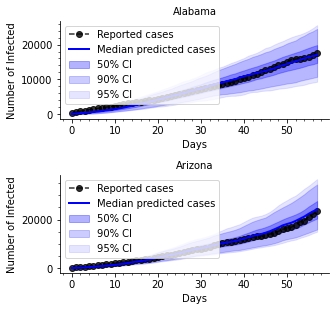

In [24]:
plot_predictions(500, data_dict, sim_diff=20, cumulative=True, figsize=(4.7747,  1.5* 2.9509))

# Publication figures

## Calibration

In [25]:
from scipy.stats import binom

def plot_sbc(theta_samples, theta_test, param_names, bins=25,
            figsize=(24, 12), interval=0.99, show=True, filename=None, font_size=12):
    """
    Plots the simulation-based posterior checking histograms as advocated by Talts et al. (2018).
    """

    # Plot settings

    N = int(theta_test.shape[0])

    f, axarr = plt.subplots(6, 5, figsize=figsize)
    axarr = axarr.flat

    sns.axes_style({'font.family': ['serif'],
                'font.sans-serif': ['stix']
                })

    # Convert theta test to numpy
    theta_test = theta_test.numpy()

    # Compute ranks (using broadcasting)    
    ranks = np.sum(theta_samples < theta_test, axis=0)
    
    # Compute interval
    endpoints = binom.interval(interval, N, 1 / (bins+1))

    # Plot histograms
    for j in range(len(param_names)):
        
        
        # Add interval
        axarr[j].axhspan(endpoints[0], endpoints[1], facecolor='gray', alpha=0.3)
        axarr[j].axhline(np.mean(endpoints), color='gray', zorder=0, alpha=0.5)
        
        
        sns.distplot(ranks[:, j], kde=False, ax=axarr[j], color='#a34f4f',
                        hist_kws=dict(edgecolor="k", linewidth=1,alpha=1.), bins=bins)
        
        axarr[j].set_title(param_names[j])
        axarr[j].spines['right'].set_visible(False)
        axarr[j].spines['top'].set_visible(False)
        if j == 0:
            axarr[j].set_xlabel('Rank statistic')
        axarr[j].get_yaxis().set_ticks([])
    
    f.tight_layout()
    
    # Show, if specified
    if show:
        plt.show()
        
    # Save if specified
    if filename is not None:
        f.savefig("/content/drive/MyDrive/AIAgainstCorona-main/us_figures/{}.pdf".format(filename))

In [26]:
test_data_sbc = data_gen(2500)
theta_samples = np.concatenate([model.sample(x, 250, to_numpy=True) 
                                for x in tf.split(test_data_sbc['x'], 10, axis=0)], axis=1)

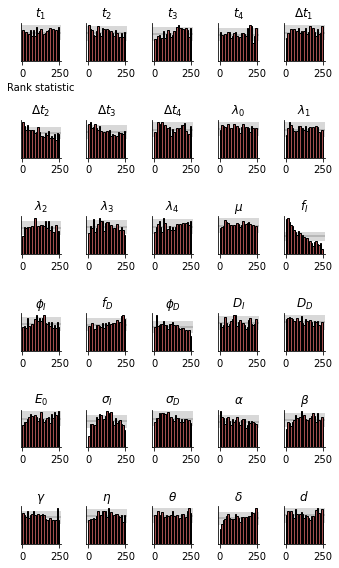

In [27]:
plot_sbc(theta_samples, test_data_sbc['theta'], param_names, bins=25,  figsize=(4.7747, 8), filename='SBC_States')

## Predictions

In [28]:
#data_dict_p = load_all_data(end_date='2020-06-05')
#T = data_dict_p['Alabama']['x'].shape[0]

## Full posteriors

In [29]:
from sklearn.neighbors import KernelDensity

def estimate_map(samples):
    
    bw = 1.06 * samples.std() * samples.size ** (-1 / 5.)
    scores = KernelDensity(bandwidth=bw).fit(samples.reshape(-1, 1)).score_samples(samples.reshape(-1, 1))
    max_i = scores.argmax()
    map_i = samples[max_i]
    return map_i

def get_kde(samples):
    """Returns sorted kdes."""
    bw = 1.06 * samples.std() * samples.size ** (-1 / 5.)
    kde = KernelDensity(bandwidth=bw).fit(samples.reshape(-1, 1))
    x_plot = np.linspace(samples.min() - 0.001, samples.max() + 0.001, 10000)
    y_plot = np.exp(kde.score_samples(x_plot[:, np.newaxis]))
    return x_plot, y_plot

In [30]:
def plot_posteriors_state(state, n_samples, data_dict, figsize=(24, 10), 
                          font_size=16, bins=30, map_samples=5000, filename=None):
    """Plots full posteriors for each state."""
    
    # Plot settings
    plt.rcParams['font.size'] = font_size
    
    
    norm_data = (data_dict[state]['x_tensor'] - grand_mean) / grand_std
    samples = model.sample(norm_data, n_samples, to_numpy=True)
    idx_nonzero = [i for i, e in enumerate(param_names) if e != '$\\phi_I$' and e != '$\\phi_D$']
    samples = samples[np.sum(samples[:, idx_nonzero] < 0, axis=1) == 0]
    idx_alpha = param_names.index('$\\alpha$')
    idx_theta = param_names.index('$\\theta$')
    print('Number of valid samples: ', samples.shape[0])
    
    f, ax = plt.subplots(8, 4, figsize=figsize)
    for i in range(theta_dim):
        
        
        x_fill, y_fill = get_kde(prior_samples[:, i])
        ax.flat[i].plot(x_fill, y_fill, alpha=0.5, color='gray', lw=3, label='Prior')
        sns.histplot(samples[:, i], kde=False, bins=bins, ax=ax.flat[i], stat='density',
                     color='#a34f4f', element='step', label='Posterior')
        ax.flat[i].spines['right'].set_visible(False)
        ax.flat[i].spines['top'].set_visible(False)
        ax.flat[i].axvline(np.median(samples[:, i]), color='black', linestyle='dashed')
        ax.flat[i].set_title(param_names[i], pad=0.4)
        if i == idx_alpha or i == idx_theta:
            align = 'right'
            xx = 0.4
        else:
            align = 'left'
            xx = 0.7
            
        if i == 0:
            #lg = f.legend(loc='lower right', bbox_to_anchor=(0.5, -0.01), 
            #         ncol=2, fontsize=8, borderaxespad=1)
            pass
            
        if i >= 30:
          ax.flat[i].set_axis_off()
        # Change points
        if i < 4:
            xlabels = [days[int(x)] for x in ax.flat[i].get_xticks()]
            #ax.flat[i].set_xticklabels(xlabels, rotation=30)
 
        med = np.median(samples[:, i])
        MAP = estimate_map(samples[:map_samples, i])
        """ax.flat[i].text(xx, 0.85, r'$MAP={:.2f}$'.format(MAP),
                     horizontalalignment=align,
                     verticalalignment='center',
                     transform=ax.flat[i].transAxes,
                     size=12)
        ax.flat[i].text(xx, 0.6, r'$Med={:.2f}$'.format(med),
                     horizontalalignment=align,
                     verticalalignment='center',
                     transform=ax.flat[i].transAxes,
                     size=12)"""
        
        ax.flat[i].set_ylabel('')
        ax.flat[i].set_yticks([])
        
    f.tight_layout()
    f.subplots_adjust(bottom=0.07)
    
    # Save if specified
    if filename is not None:
        f.savefig("/content/drive/MyDrive/AIAgainstCorona-main/us_figures/{}.pdf".format(filename), bbox_inches='tight')

In [31]:
days = ['March {}'.format(i) for i in range(1, 32)] + \
       ['April {}'.format(i) for i in range (1, 31)] + \
       ['May {}'.format(i) for i in range(1, 21)]

In [32]:
n_prior_samples = 6000
prior_samples = np.array([prior_sir() + prior_secir() for _ in range(n_prior_samples)])

Number of valid samples:  61448
Number of valid samples:  65067
Number of valid samples:  62527
Number of valid samples:  1745
Number of valid samples:  19377
Number of valid samples:  159
Number of valid samples:  55195
Number of valid samples:  560
Number of valid samples:  6333
Number of valid samples:  472
Number of valid samples:  69646
Number of valid samples:  64277
Number of valid samples:  63841
Number of valid samples:  4632
Number of valid samples:  5333
Number of valid samples:  160
Number of valid samples:  258
Number of valid samples:  66332
Number of valid samples:  48346
Number of valid samples:  59960
Number of valid samples:  65780
Number of valid samples:  523
Number of valid samples:  66042
Number of valid samples:  56986
Number of valid samples:  3764
Number of valid samples:  62843
Number of valid samples:  65687
Number of valid samples:  136
Number of valid samples:  9225
Number of valid samples:  58983
Number of valid samples:  66794
Number of valid samples:  19

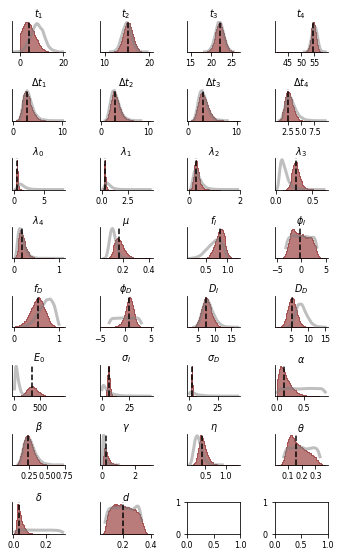

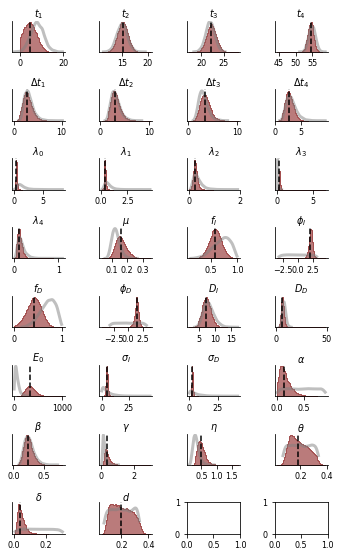

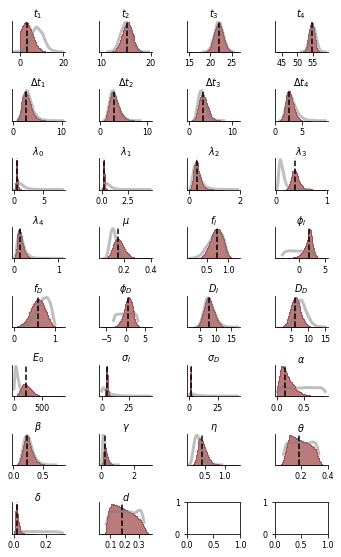

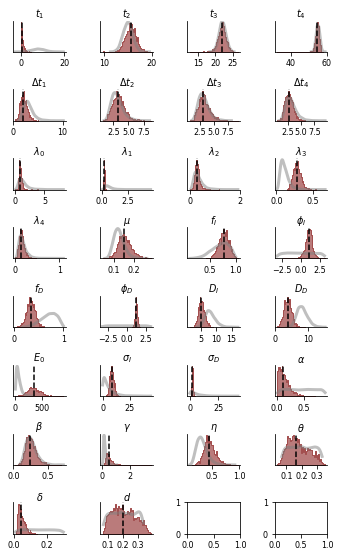

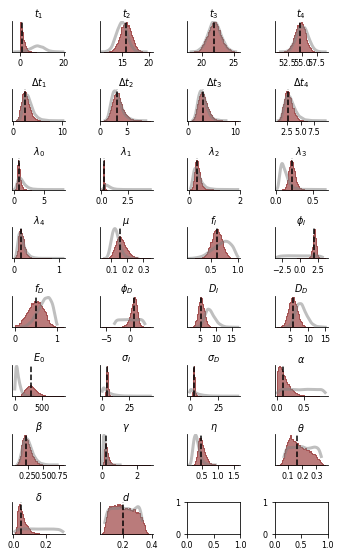

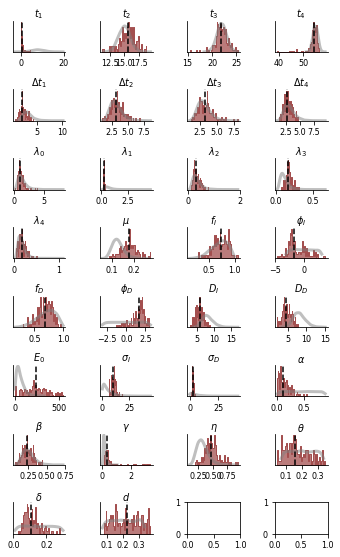

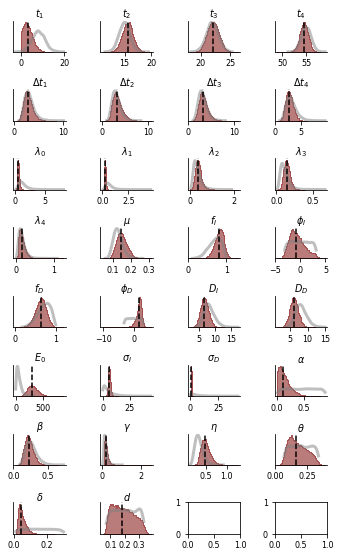

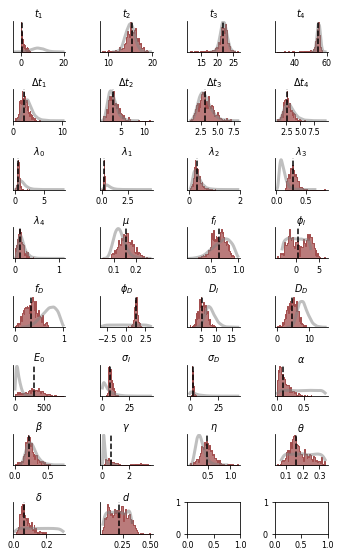

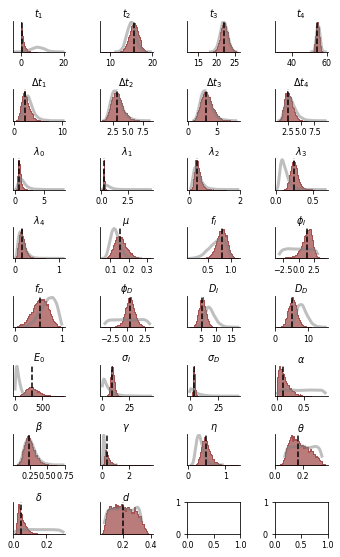

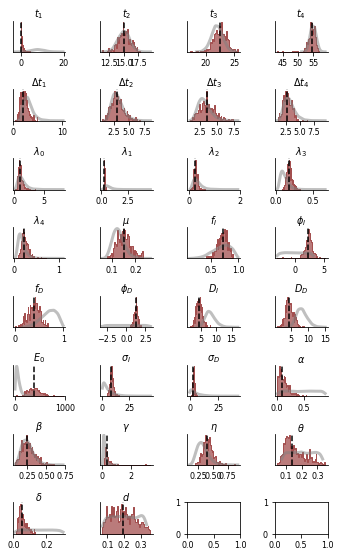

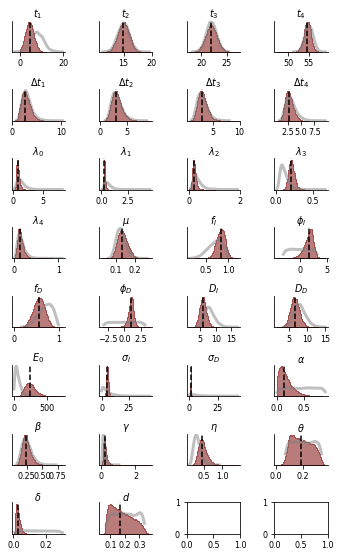

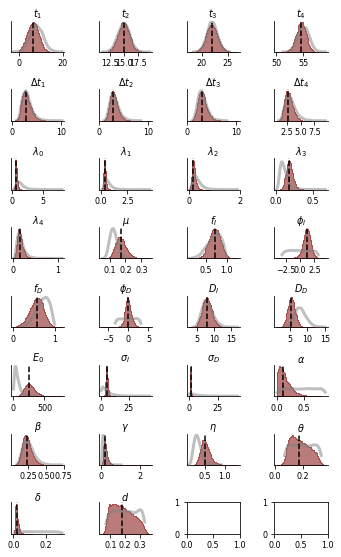

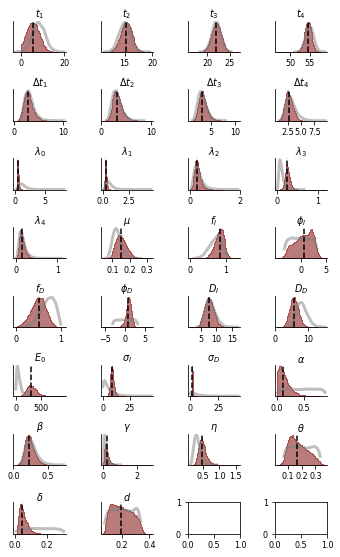

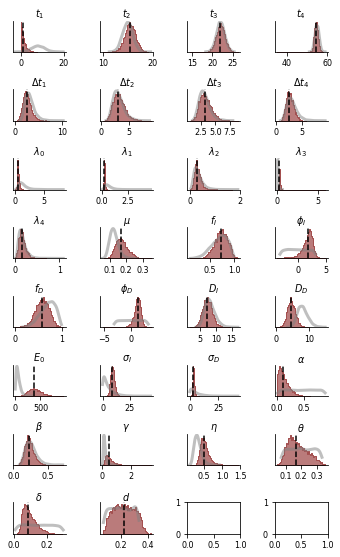

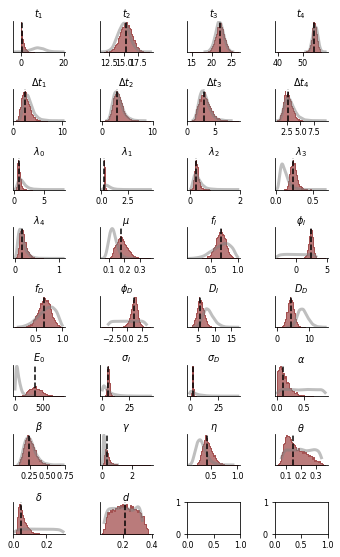

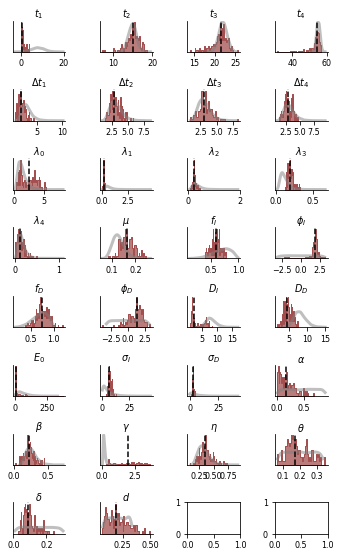

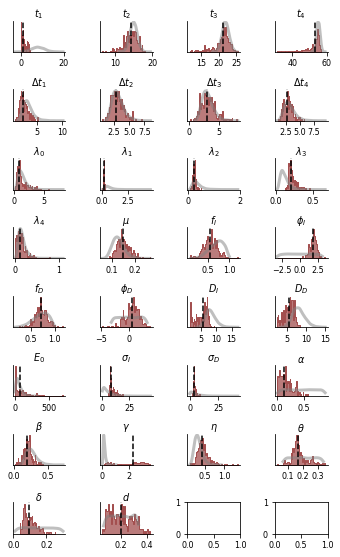

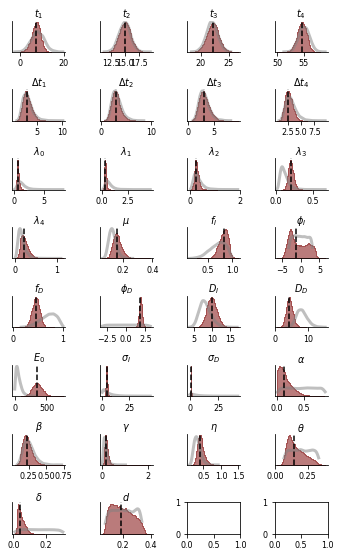

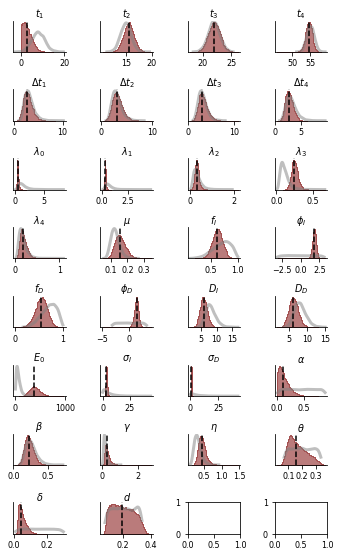

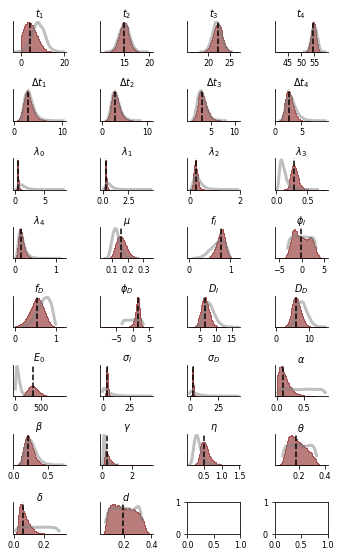

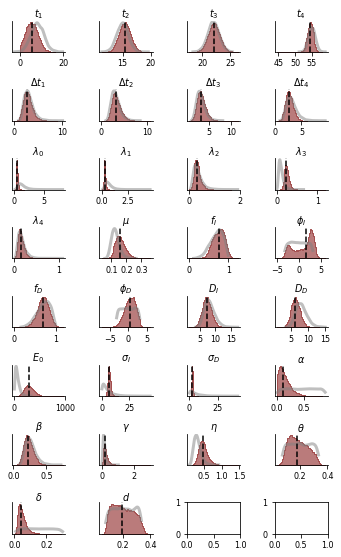

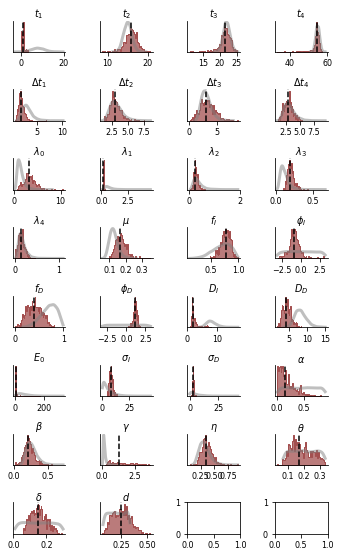

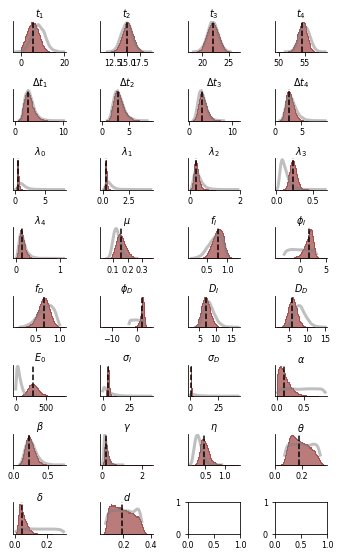

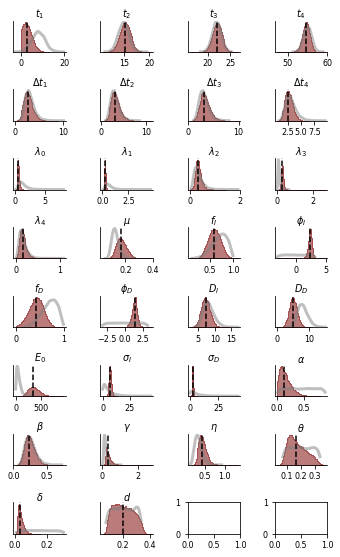

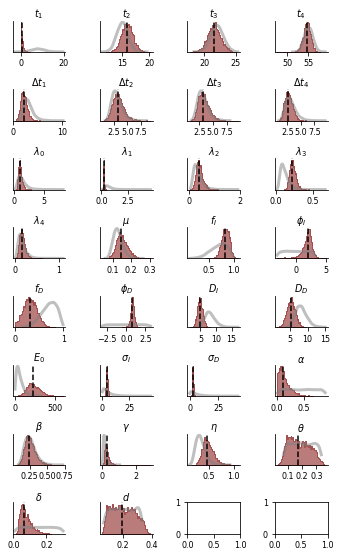

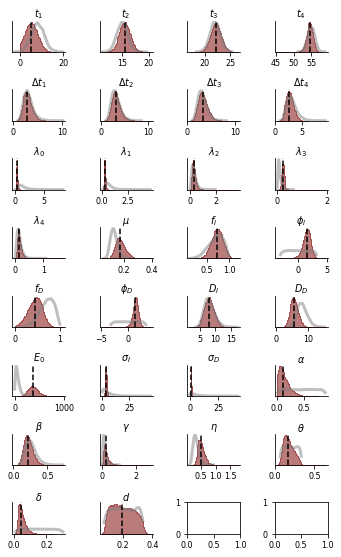

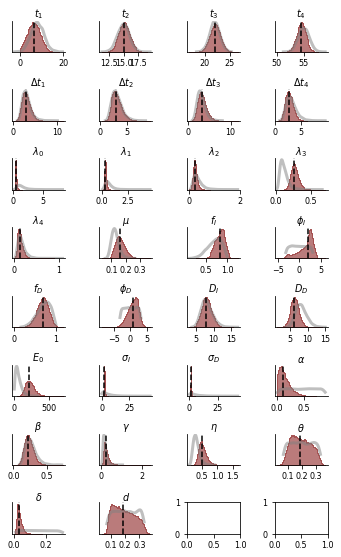

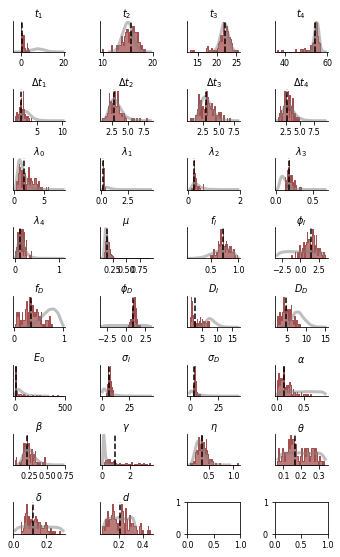

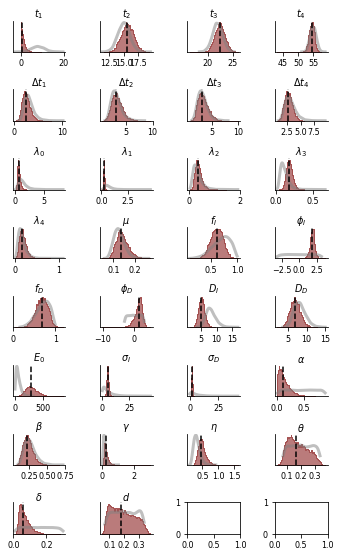

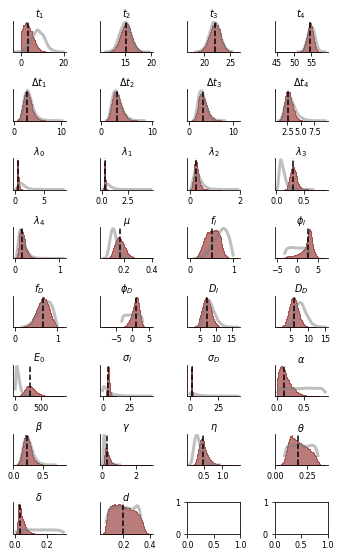

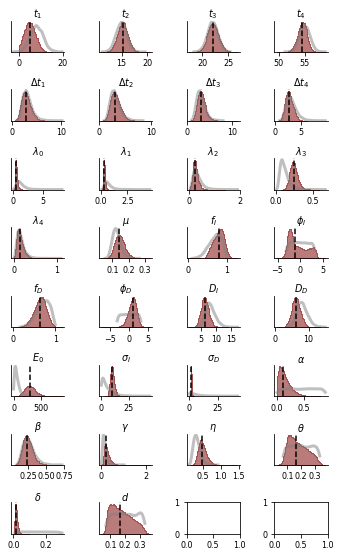

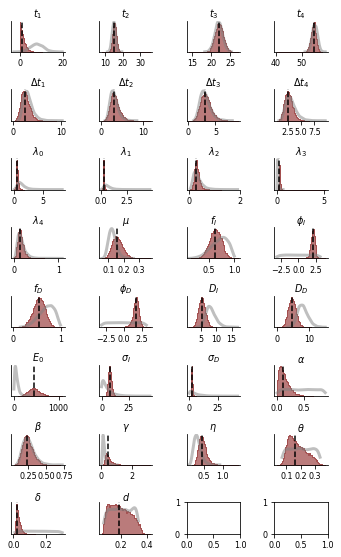

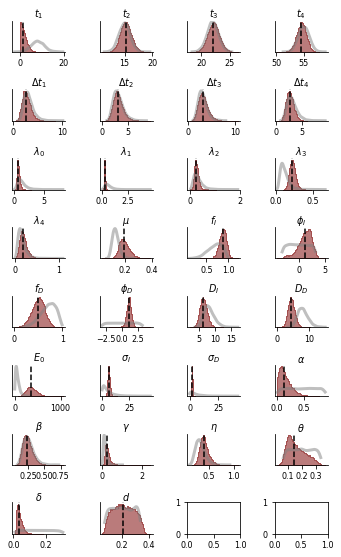

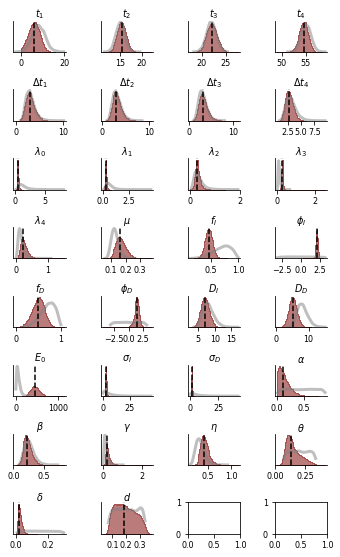

In [33]:
states = [
          "Alabama"
          ]

#small_data_dict = {key: data_dict[key] for key in states}
small_data_dict = data_dict

for state in small_data_dict:
    plot_posteriors_state(state, 75000, 
                          data_dict, 
                          figsize=(4.7747, 8), 
                          font_size=8,
                          bins=50, 
                          filename=state+f'_post')

## Tables

In [34]:
param_tex = ['$t_1$', '$t_2$', '$t_3$', '$t_4$',
             '$\Delta t_1$', '$\Delta t_2$', '$\Delta t_3$', '$\Delta t_4$',
               '$\lambda_0$', '$\lambda_1$', '$\lambda_2$', '$\lambda_3$', '$\lambda_4$', 
               '$\mu$', '$f_I$', '$\phi_I$',
               '$f_D$', '$\phi_D$',
               '$D_I$', '$D_D$', '$E_0$', '$\sigma_I$','$\sigma_D$', 
               '$\alpha$', '$\beta$', '$\gamma$',
               '$\eta$', '$\theta$', '$\delta$', r'$d$']

def estimate_map(samples):
    
    bw = 1.06 * samples.std() * samples.size ** (-1 / 5.)
    scores = KernelDensity(bandwidth=bw).fit(samples.reshape(-1, 1)).score_samples(samples.reshape(-1, 1))
    max_i = scores.argmax()
    map_i = samples[max_i]
    return map_i

def create_table(state, data, model, n_samples=10000, save_name='/content/drive/MyDrive/AIAgainstCorona-main/posterior_estimates/some_df.csv'):
    """Prepares a table with posterior summaries."""
    
    
    norm_data = (data[state]['x_tensor'] - grand_mean) / grand_std
    samples = model.sample(norm_data, n_samples, to_numpy=True)
    idx_nonzero = [i for i, e in enumerate(param_names) if e != '$\\phi_I$' and e != '$\\phi_D$']
    samples = samples[np.sum(samples[:, idx_nonzero] < 0, axis=1) == 0]
    idx_alpha = param_names.index('$\\alpha$')
    print('Number of valid samples: ', samples.shape[0])  
    
    # Compute quantiles and medians
    qs_95 = np.quantile(samples, q=[0.025, 0.975], axis=0)
    qs_95_str = ['[{0:.3f} - {1:.3f}]'.format(qs_95[0, i], qs_95[1, i]) for i in range(len(param_names))]
    meds = np.array(['{0:.3f}'.format(m) for m in np.median(samples, axis=0)])
    means = np.array(['{0:.3f}'.format(m) for m in np.mean(samples, axis=0)])
    maps = np.array(['{0:.3f}'.format(estimate_map(samples[:, i])) for i in range(len(param_names))])
    
    # Prepare table
    table = pd.DataFrame(index=param_tex, data={'Median': meds, 'Mean': means, 'MAP': maps, '95-CI': qs_95_str})
    table.to_csv(save_name)
    return table

In [ ]:
for state in small_data_dict:
    print('Creating table for: ', state)
    t = create_table(state, small_data_dict, model, save_name=(f'/content/drive/MyDrive/AIAgainstCorona-main/posterior_estimates/{state}.csv'))
    latex_string = t.to_latex(escape=False)
    with open('/content/drive/MyDrive/AIAgainstCorona-main/tables/{}.tex'.format(state), 'w+') as f:
        f.write(latex_string)

Creating table for:  Alabama
Number of valid samples:  8162
Creating table for:  Arizona
Number of valid samples:  8649
Creating table for:  Arkansas
Number of valid samples:  8416
Creating table for:  California
Number of valid samples:  206
Creating table for:  Colorado
Number of valid samples:  2546
Creating table for:  Connecticut
Number of valid samples:  23
Creating table for:  Delaware
Number of valid samples:  7394
Creating table for:  Florida
Number of valid samples:  80
Creating table for:  Georgia
Number of valid samples:  840
Creating table for:  Illinois
Number of valid samples:  66
Creating table for:  Iowa
Number of valid samples:  9300
Creating table for:  Kansas
Number of valid samples:  8617
Creating table for:  Kentucky
Number of valid samples:  8502
Creating table for:  Louisiana
Number of valid samples:  579
Creating table for:  Maryland
Number of valid samples:  730
Creating table for:  Massachusetts
Number of valid samples:  25
Creating table for:  Michigan
Numbe

## Forest plots

In [ ]:
n_post_samples = 5000
samples_to_use = 2000
univariates = []
univariates_dict = {s: None for s in data_dict}
for state in data_dict:
    norm_data = (data_dict[state]['x_tensor'] - grand_mean) / grand_std
    samples = model.sample(norm_data, n_post_samples, to_numpy=True)
    idx_nonzero = [i for i, e in enumerate(param_names) if e != '$\\phi_I$' and e != '$\\phi_D$']
    samples = samples[np.sum(samples[:, idx_nonzero] < 0, axis=1) == 0]
    print('Number of valid samples: ', samples.shape[0])
    idx_e0 = param_names.index('$E_0$')
    univariates.append(samples[:samples_to_use, idx_e0])
    univariates_dict[state] = samples[:samples_to_use, idx_e0]
univariates = np.array(univariates).T

In [ ]:
import arviz as az
f, ax = plt.subplots(1, 1, figsize=(16, 10))
d = az.convert_to_inference_data(univariates_dict)
az.plot_forest(d,
              kind='forestplot',
              combined=True,
              ridgeplot_quantiles=[.025, .5, .975],
              ridgeplot_overlap=0.9,
              quartiles=True,
              textsize=16,
              linewidth=2.5,
              hdi_prob=0.95,
              markersize=10.,
              colors = '#415ab5',
              ax=ax)

ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
ax.set_xlabel(r'Number of initially exposed ($E_0$)', fontsize=16)
ax.set_title('')
f.savefig("/content/drive/MyDrive/AIAgainstCorona-main/figures/Initially_Exposed.png", dpi=300, bbox_inches='tight')

In [ ]:
n_post_samples = 5000
samples_to_use = 2000
univariates = []
univariates_dict = {s: None for s in data_dict}
for state in data_dict:
    norm_data = (data_dict[state]['x_tensor'] - grand_mean) / grand_std
    samples = model.sample(norm_data, n_post_samples, to_numpy=True)
    idx_nonzero = [i for i, e in enumerate(param_names) if e != '$\\phi_I$' and e != '$\\phi_D$']
    samples = samples[np.sum(samples[:, idx_nonzero] < 0, axis=1) == 0]
    print('Number of valid samples: ', samples.shape[0])
    idx_e0 = param_names.index('$\\lambda_0$')
    univariates.append(samples[:samples_to_use, idx_e0])
    univariates_dict[state] = samples[:samples_to_use, idx_e0]
univariates = np.array(univariates).T

In [ ]:
print('Global median: ', np.median(univariates))

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(16, 10))
d = az.convert_to_inference_data(univariates_dict)
az.plot_forest(d,
              kind='forestplot',
              combined=True,
              ridgeplot_quantiles=[.025, .5, .975],
              ridgeplot_overlap=0.9,
              quartiles=True,
              textsize=16,
              linewidth=2.5,
              hdi_prob=0.95,
              markersize=10.,
              colors = '#415ab5',
              ax=ax)

ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
ax.set_xlabel(r'Initial transmission rate ($\lambda_0$)', fontsize=16)
ax.set_title('')
f.savefig('/content/drive/MyDrive/AIAgainstCorona-main/figures/Lambda_zero.png', dpi=300, bbox_inches='tight')

In [ ]:
n_post_samples = 5000
samples_to_use = 2000
univariates = []
univariates_dict = {s: None for s in data_dict}
for state in data_dict:
    norm_data = (data_dict[state]['x_tensor'] - grand_mean) / grand_std
    samples = model.sample(norm_data, n_post_samples, to_numpy=True)
    idx_nonzero = [i for i, e in enumerate(param_names) if e != '$\\phi_I$' and e != '$\\phi_D$']
    samples = samples[np.sum(samples[:, idx_nonzero] < 0, axis=1) == 0]
    print('Number of valid samples: ', samples.shape[0])
    idx_e0 = param_names.index('$\\alpha$')
    univariates.append(samples[:samples_to_use, idx_e0])
    univariates_dict[state] = samples[:samples_to_use, idx_e0]
univariates = np.array(univariates).T

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(16, 10))
d = az.convert_to_inference_data(univariates_dict)
az.plot_forest(d,
              kind='forestplot',
              combined=True,
              ridgeplot_quantiles=[.025, .5, .975],
              ridgeplot_overlap=0.9,
              quartiles=True,
              textsize=16,
              linewidth=2.5,
              hdi_prob=0.95,
              markersize=10.,
              colors = '#415ab5',
              ax=ax)

ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
ax.set_xlabel(r'Probability of remaining undiagnosed ($\alpha$)', fontsize=16)
ax.set_title('')
f.savefig('/content/drive/MyDrive/AIAgainstCorona-main/figures/Alpha.png', dpi=300, bbox_inches='tight')

In [ ]:
n_post_samples = 5000
samples_to_use = 2000
univariates = []
univariates_dict = {s: None for s in data_dict}
for state in data_dict:
    norm_data = (data_dict[state]['x_tensor'] - grand_mean) / grand_std
    samples = model.sample(norm_data, n_post_samples, to_numpy=True)
    idx_nonzero = [i for i, e in enumerate(param_names) if e != '$\\phi_I$' and e != '$\\phi_D$']
    samples = samples[np.sum(samples[:, idx_nonzero] < 0, axis=1) == 0]
    print('Number of valid samples: ', samples.shape[0])
    idx_e0 = param_names.index('$\\theta$')
    univariates.append(samples[:samples_to_use, idx_e0])
    univariates_dict[state] = samples[:samples_to_use, idx_e0]
univariates = np.array(univariates).T

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(16, 10))
d = az.convert_to_inference_data(univariates_dict)
az.plot_forest(d,
              kind='forestplot',
              combined=True,
              ridgeplot_quantiles=[.025, .5, .975],
              ridgeplot_overlap=0.9,
              quartiles=True,
              textsize=16,
              linewidth=2.5,
              hdi_prob=0.95,
              markersize=10.,
              colors = '#415ab5',
              ax=ax)

ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
ax.set_xlabel(r'Recovery rate of undiagnosed ($\theta$)', fontsize=16)
ax.set_title('')
f.savefig('/content/drive/MyDrive/AIAgainstCorona-main/figures/Theta.png', dpi=300, bbox_inches='tight')